In [ ]:
!pip install segmentation-models-pytorch
!pip install albumentations
!pip install -q kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
# Get all image paths
image_paths = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')
print(f"Total images: {len(image_paths)}")

# Split into train and test
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
print(f"Train: {len(train_paths)}, Test: {len(test_paths)}")

Total images: 3929
Train: 3143, Test: 786


In [ ]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        mask_path = self.image_paths[idx]
        image_path = mask_path.replace('_mask', '')

        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        image = image / 255.0

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.float32)

        # Convert to tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

# Create datasets
train_dataset = BrainMRIDataset(train_paths)
test_dataset = BrainMRIDataset(test_paths)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Create U-Net model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Model ready!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model ready!


In [ ]:
# Train for 20 epochs
epochs = 20
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

print("Training complete!")

Epoch 1/20, Loss: 0.0122
Epoch 2/20, Loss: 0.0101
Epoch 3/20, Loss: 0.0101
Epoch 4/20, Loss: 0.0084
Epoch 5/20, Loss: 0.0076
Epoch 6/20, Loss: 0.0079
Epoch 7/20, Loss: 0.0066
Epoch 8/20, Loss: 0.0065
Epoch 9/20, Loss: 0.0061
Epoch 10/20, Loss: 0.0071
Epoch 11/20, Loss: 0.0058
Epoch 12/20, Loss: 0.0055
Epoch 13/20, Loss: 0.0052
Epoch 14/20, Loss: 0.0059
Epoch 15/20, Loss: 0.0047
Epoch 16/20, Loss: 0.0053
Epoch 17/20, Loss: 0.0053
Epoch 18/20, Loss: 0.0045
Epoch 19/20, Loss: 0.0044
Epoch 20/20, Loss: 0.0041
Training complete!


In [ ]:
def dice_coefficient(pred, target):
    smooth = 1e-5
    pred = torch.sigmoid(pred) > 0.5
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Evaluate
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        dice = dice_coefficient(outputs, masks)
        dice_scores.append(dice.item())

avg_dice = np.mean(dice_scores)
print(f"Average Dice Coefficient: {avg_dice:.4f}")

Average Dice Coefficient: 0.8747


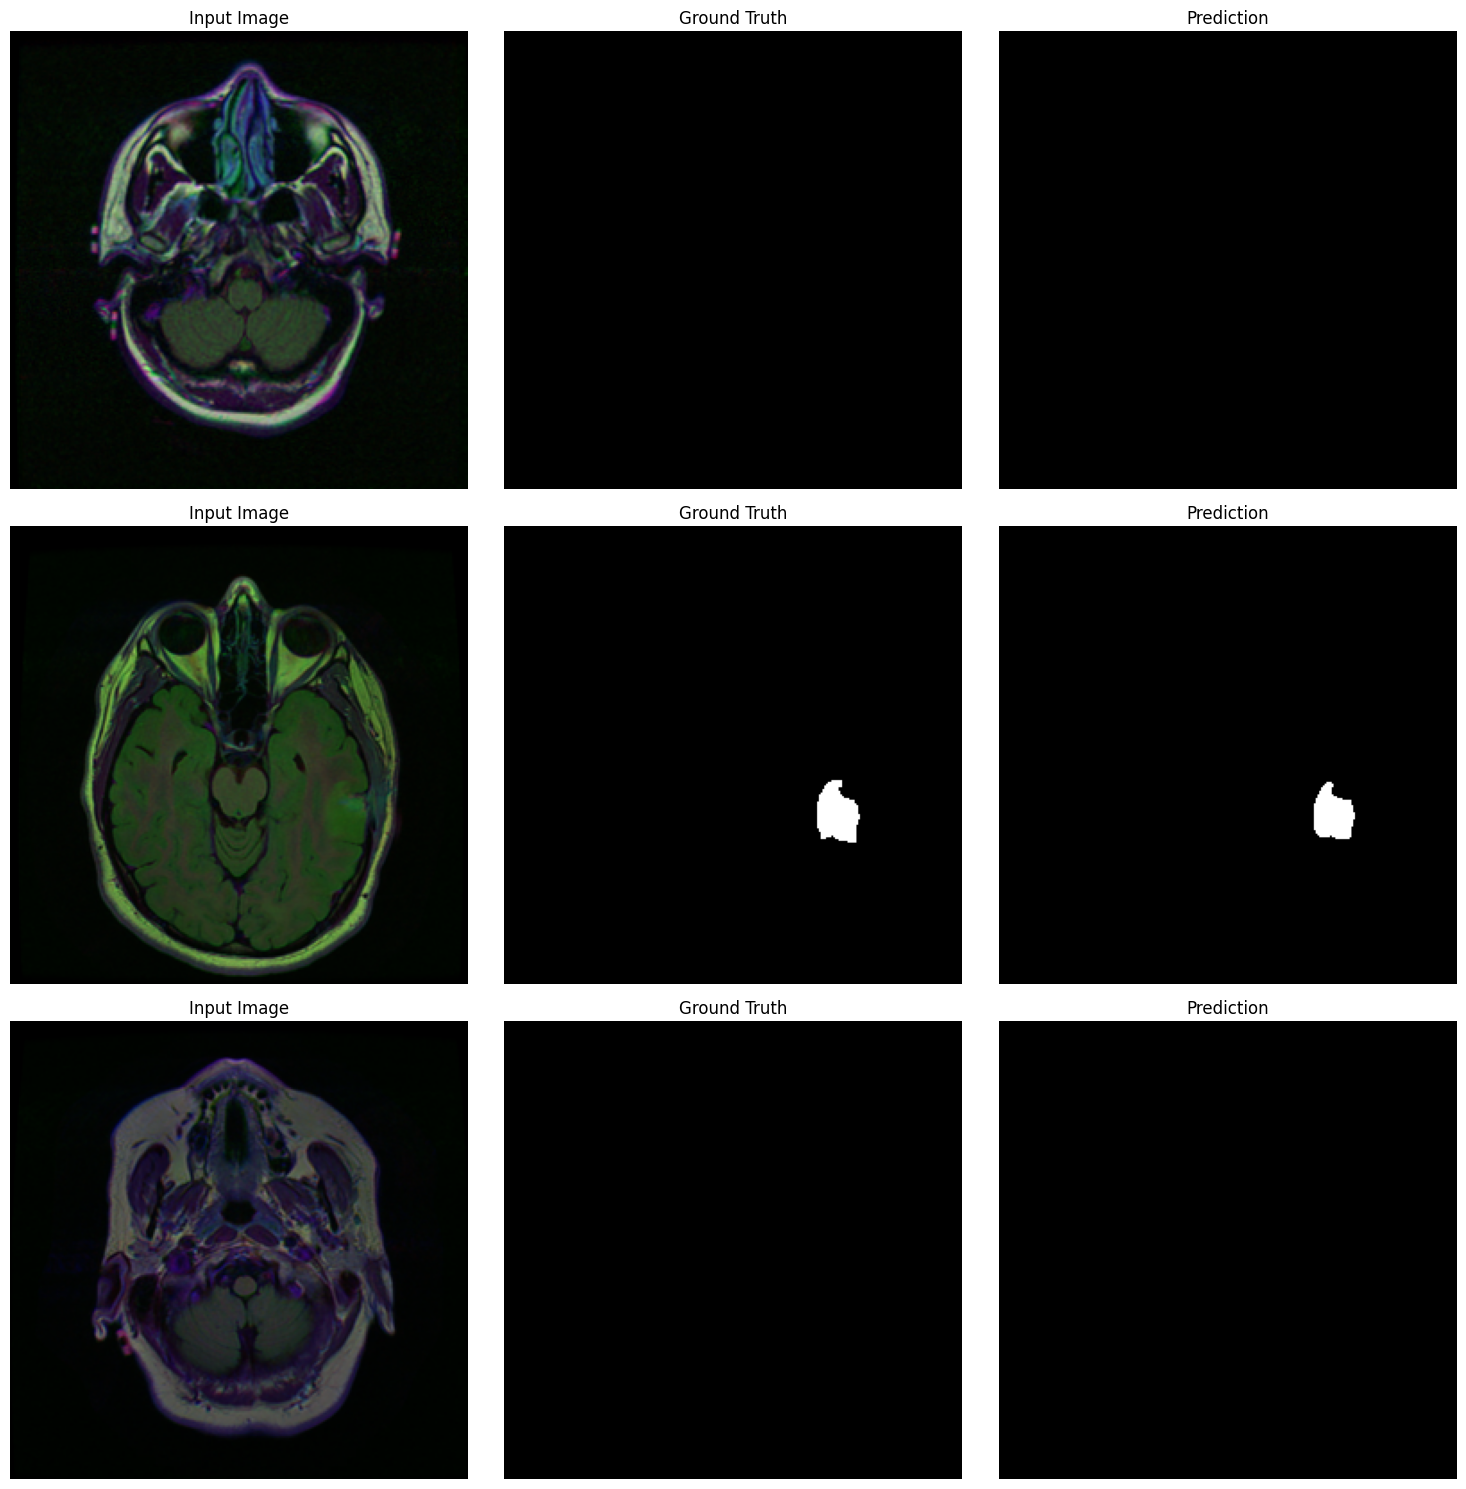

In [ ]:
# Show some predictions
model.eval()
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

with torch.no_grad():
    for i in range(3):
        image, mask = test_dataset[i]
        image_input = image.unsqueeze(0).to(device)

        pred = model(image_input)
        pred = torch.sigmoid(pred) > 0.5
        pred = pred.cpu().squeeze().numpy()

        # Plot
        axes[i, 0].imshow(image.permute(1, 2, 0))
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('results.png', dpi=150, bbox_inches='tight')
plt.show()

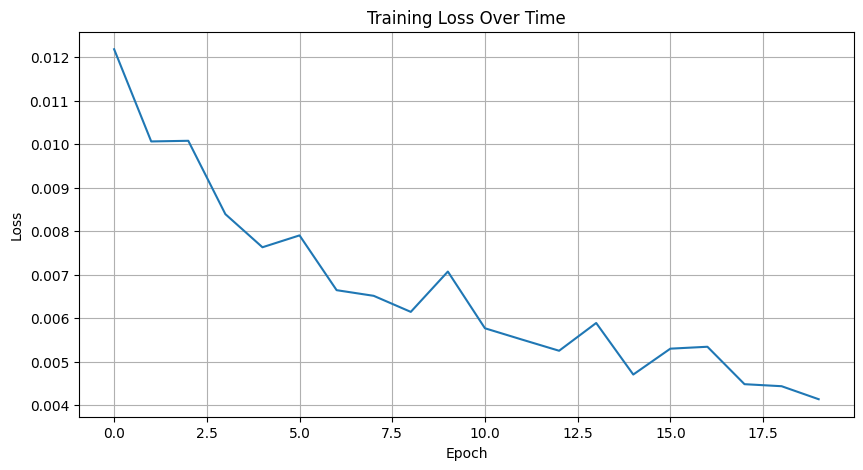

In [ ]:
# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.savefig('training_curve.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Additional metrics
def calculate_iou(pred, target):
    pred = torch.sigmoid(pred) > 0.5
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-5) / (union + 1e-5)

# Calculate IoU
iou_scores = []
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        iou = calculate_iou(outputs, masks)
        iou_scores.append(iou.item())

avg_iou = np.mean(iou_scores)
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice: {avg_dice:.4f}")

Average IoU: 0.7887
Average Dice: 0.8747
